# XLK Next-Day Nowcast
Predict tomorrow's return of XLK (Technology ETF) using simple features:
 - Market controls: SPY, VIX
 - Momentum & volatility features on XLK
This is a learning project for Python + basic ML on time series.

In [19]:
import sys, platform
print("Python:", sys.version)
print("Executable:", sys.executable)

Python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
Executable: c:\Users\nadoy\OneDrive\Desktop\DS PROJECTS\stock-nowcast\.venv\Scripts\python.exe


In [20]:
import pandas as pd, numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from joblib import dump

plt.rcParams["figure.figsize"] = (10,5)
pd.set_option("display.float_format", lambda x: f"{x:,.6f}")


Download Prices (XLK target, SPY & VIX as features)

In [21]:
tickers = ["XLK", "SPY", "^VIX"] # Tech sector, market, volatility
px = yf.download(tickers, start="2015-01-01", auto_adjust=True, threads=False)["Close"].dropna()
px.columns = ["XLK", "SPY", "VIX"]
px.head

[*********************100%***********************]  3 of 3 completed


<bound method NDFrame.head of                   XLK        SPY       VIX
Date                                      
2015-01-02 171.568039  36.315060 17.790001
2015-01-05 168.469574  35.760704 19.920000
2015-01-06 166.882767  35.329525 21.120001
2015-01-07 168.962326  35.628708 19.309999
2015-01-08 171.960571  36.411846 17.010000
...               ...        ...       ...
2025-08-22 645.309998 262.420013 14.220000
2025-08-25 642.469971 261.829987 14.790000
2025-08-26 645.159973 263.029999 14.620000
2025-08-27 646.630005 264.450012 14.850000
2025-08-28 648.919983 266.540009 14.430000

[2680 rows x 3 columns]>

In [22]:
# Daily returns
ret = px.pct_change().dropna()
ret.columns = ["ret_xlk", "ret_spy", "ret_vix"]

# Feature table
feat = pd.DataFrame(index=ret.index)
feat["ret_xlk"] = ret["ret_xlk"]
feat["ret_spy"] = ret["ret_spy"]
feat["ret_vix"] = ret["ret_vix"]

# Momentum and volatility features on XLK
feat["mom_5"] = ret["ret_xlk"].rolling(5).mean()
feat["mom_10"] = ret["ret_xlk"].rolling(10).mean()
feat["vol_10"] = ret["ret_xlk"].rolling(10).std()
feat["vol_20"] = ret["ret_xlk"].rolling(20).std()

feat = feat.dropna()

# Shift featuers by 1 day so they're known before predicting next day
X = feat[["ret_spy", "ret_vix", "mom_5", "mom_10", "vol_10", "vol_20"]].shift(1).dropna()
y = feat.loc[X.index, "ret_xlk"]

X.tail(), y.tail()

(             ret_spy   ret_vix     mom_5   mom_10   vol_10   vol_20
 Date                                                               
 2025-08-22 -0.003617  0.057999 -0.002931 0.000533 0.005218 0.006778
 2025-08-25  0.013557 -0.143373  0.000609 0.001289 0.006719 0.007547
 2025-08-26 -0.002248  0.040084 -0.000228 0.001047 0.006891 0.007630
 2025-08-27  0.004583 -0.011494  0.001695 0.000401 0.006155 0.007637
 2025-08-28  0.005399  0.015732  0.002682 0.000286 0.006103 0.007628,
 Date
 2025-08-22    0.015357
 2025-08-25   -0.004401
 2025-08-26    0.004187
 2025-08-27    0.002279
 2025-08-28    0.003541
 Name: ret_xlk, dtype: float64)

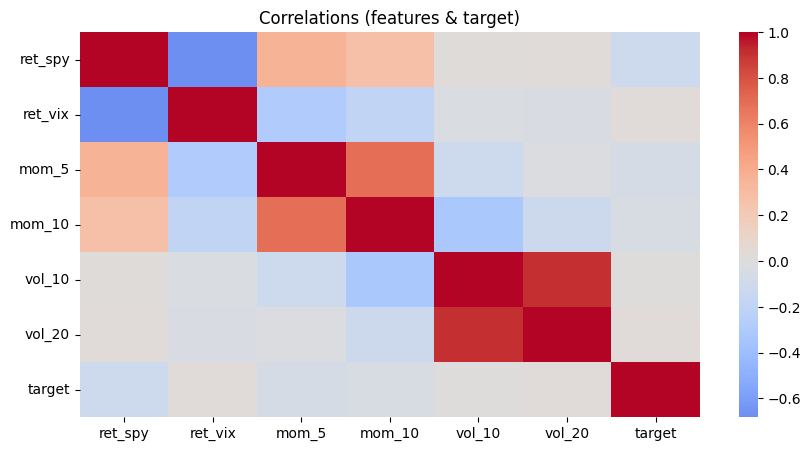

In [23]:
sns.heatmap(pd.concat([X, y.rename("target")], axis=1).corr(), cmap="coolwarm", center=0)
plt.title("Correlations (features & target)"); plt.show()


In [24]:
split = int(0.8 * len(X))
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]
len(X_train), len(X_test)


(2127, 532)

In [25]:
def evaluate_preds(y_true, y_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # returns MSE
    rmse = np.sqrt(mse)                       # convert to RMSE manually
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return {"MAE": mae, "RMSE": rmse, "Directional_Accuracy": dir_acc}


baseline_zero = np.zeros_like(y_test)
baseline_lag1 = y_test.shift(1).fillna(0.0).values

print("Baseline Zero:", evaluate_preds(y_test, baseline_zero))
print("Baseline Lag-1:", evaluate_preds(y_test, baseline_lag1))


Baseline Zero: {'MAE': 0.006669483368685103, 'RMSE': np.float64(0.010217363660128658), 'Directional_Accuracy': np.float64(0.0018796992481203006)}
Baseline Lag-1: {'MAE': 0.009813052714517703, 'RMSE': np.float64(0.014960095183936166), 'Directional_Accuracy': np.float64(0.5112781954887218)}


In [26]:
ridge = Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])
lasso = Pipeline([("scaler", StandardScaler()), ("model", Lasso(alpha=0.0005, max_iter=10000))])

ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

pred_ridge = ridge.predict(X_test)
pred_lasso = lasso.predict(X_test)

print("Ridge:", evaluate_preds(y_test, pred_ridge))
print("Lasso:", evaluate_preds(y_test, pred_lasso))


Ridge: {'MAE': 0.006709398151798528, 'RMSE': np.float64(0.010147842993836509), 'Directional_Accuracy': np.float64(0.5225563909774437)}
Lasso: {'MAE': 0.006654946525029269, 'RMSE': np.float64(0.010175122884003187), 'Directional_Accuracy': np.float64(0.5469924812030075)}


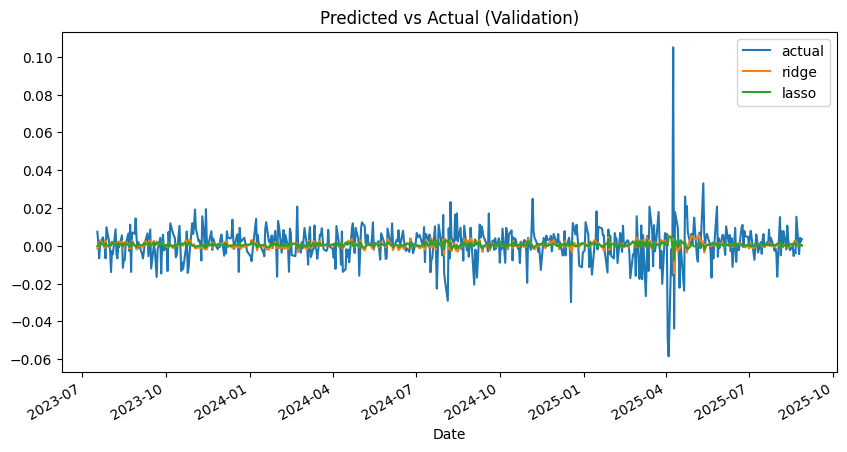

In [27]:
pd.DataFrame({"actual": y_test, "ridge": pred_ridge, "lasso": pred_lasso}).plot()
plt.title("Predicted vs Actual (Validation)"); plt.show()


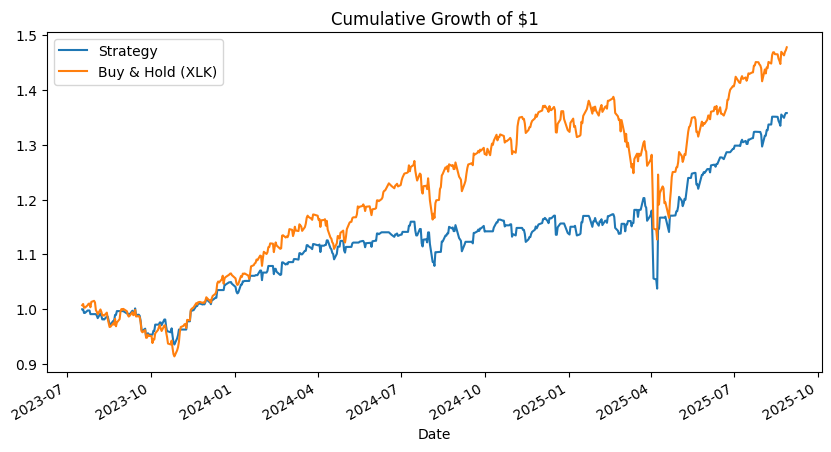

Strategy CAGR-ish: 15.59% | Buy&Hold: 20.32%


In [28]:
pred = pd.Series(pred_ridge, index=y_test.index, name="pred")
signal = (pred > 0).astype(int)          # 1=long, 0=flat
strat_ret = signal * y_test

cum_strat = (1 + strat_ret).cumprod()
cum_buyhold = (1 + y_test).cumprod()

ax = cum_strat.plot(label="Strategy")
cum_buyhold.plot(ax=ax, label="Buy & Hold (XLK)")
plt.legend(); plt.title("Cumulative Growth of $1"); plt.show()

strategy_cagr = cum_strat.iloc[-1]**(252/len(cum_strat)) - 1
buyhold_cagr  = cum_buyhold.iloc[-1]**(252/len(cum_buyhold)) - 1
print(f"Strategy CAGR-ish: {strategy_cagr:.2%} | Buy&Hold: {buyhold_cagr:.2%}")


In [29]:
dump(ridge, "../reports/ridge_model.joblib")
X_test.to_csv("../data/test_features.csv")
y_test.to_csv("../data/test_target.csv")


In [30]:
tickers = ["XLK", "SPY", "^VIX", "QQQ", "SOXX"]
px = yf.download(tickers, start="2015-01-01", auto_adjust=True)["Close"].dropna()
px.columns = ["XLK","SPY","VIX","QQQ","SOXX"]

ret = px.pct_change().dropna().rename(columns={
    "XLK":"ret_xlk", "SPY":"ret_spy", "VIX":"ret_vix", "QQQ":"ret_qqq", "SOXX":"ret_soxx"
})

feat = pd.DataFrame(index=ret.index)
for col in ["ret_xlk","ret_spy","ret_vix","ret_qqq","ret_soxx"]:
    feat[col] = ret[col]
feat["mom_5"]  = ret["ret_xlk"].rolling(5).mean()
feat["vol_10"] = ret["ret_xlk"].rolling(10).std()
feat = feat.dropna()

X = feat[["ret_spy","ret_vix","ret_qqq","ret_soxx","mom_5","vol_10"]].shift(1).dropna()
y = feat.loc[X.index, "ret_xlk"]



[*********************100%***********************]  5 of 5 completed


In [31]:
# --- Evaluation helper ---
def evaluate_preds(y_true, y_pred):
    from sklearn.metrics import mean_absolute_error, mean_squared_error
    import numpy as np
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # robust across sklearn versions
    dir_acc = np.mean(np.sign(y_true) == np.sign(y_pred))
    return {"MAE": mae, "RMSE": rmse, "Directional_Accuracy": dir_acc}

# --- Baselines ---
baseline_zero = np.zeros_like(y_test)
baseline_lag1 = y_test.shift(1).fillna(0.0).values

# --- Model Predictions ---
pred_ridge = ridge.predict(X_test)
pred_lasso = lasso.predict(X_test)

# --- Collect results ---
results = {
    "Baseline Zero": evaluate_preds(y_test, baseline_zero),
    "Baseline Lag-1": evaluate_preds(y_test, baseline_lag1),
    "Ridge Regression": evaluate_preds(y_test, pred_ridge),
    "Lasso Regression": evaluate_preds(y_test, pred_lasso),
}

import pandas as pd
results_df = pd.DataFrame(results).T
print(results_df)


                      MAE     RMSE  Directional_Accuracy
Baseline Zero    0.006669 0.010217              0.001880
Baseline Lag-1   0.009813 0.014960              0.511278
Ridge Regression 0.006709 0.010148              0.522556
Lasso Regression 0.006655 0.010175              0.546992


In [32]:
# Live forecast: imports & settings
import os, datetime as dt, numpy as np, pandas as pd
import yfinance as yf

from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib

pd.set_option("display.float_format", lambda x: f"{x:,.6f}")

# Choose your default model for live forecasts
LIVE_MODEL = "Lasso"   # "Ridge" or "Lasso"
ALPHA = 0.0005 if LIVE_MODEL == "Lasso" else 1.0

MODEL_PATH = f"models/{LIVE_MODEL.lower()}_latest.pkl"


In [33]:
def make_features(px: pd.DataFrame):
    """
    Build features consistent with the project:
    - Target: next-day XLK return (ret_xlk at t)
    - Features at time t (all shifted to avoid look-ahead):
        ret_spy (t-1), ret_vix (t-1), mom_5 (t-1), mom_10 (t-1), vol_10 (t-1), vol_20 (t-1)
    """
    ret = px.pct_change().dropna()
    feat = pd.DataFrame(index=ret.index)
    feat["ret_xlk"] = ret["XLK"]
    feat["ret_spy"] = ret["SPY"]
    feat["ret_vix"] = ret["VIX"]
    feat["mom_5"]  = ret["XLK"].rolling(5).mean()
    feat["mom_10"] = ret["XLK"].rolling(10).mean()
    feat["vol_10"] = ret["XLK"].rolling(10).std()
    feat["vol_20"] = ret["XLK"].rolling(20).std()
    feat = feat.dropna()

    # Shift features by 1 day so they are "known" at prediction time t
    X = feat[["ret_spy","ret_vix","mom_5","mom_10","vol_10","vol_20"]].shift(1).dropna()
    y = feat.loc[X.index, "ret_xlk"]
    return X, y

def build_model(model_type="Lasso", alpha=1.0):
    if model_type == "Ridge":
        return Pipeline([("scaler", StandardScaler()), ("model", Ridge(alpha=alpha))])
    else:
        return Pipeline([("scaler", StandardScaler()), ("model", Lasso(alpha=alpha, max_iter=10000))])


In [34]:
# Fetch enough history to compute rolling features reliably
END = dt.date.today()
START = END - dt.timedelta(days=365*10)  # 10 years; adjust if you like

raw = yf.download(["XLK","SPY","^VIX"], start=str(START), end=str(END),
                  auto_adjust=True, progress=False, threads=False)

# yfinance.multi returns a column MultiIndex; take Close level safely
if isinstance(raw.columns, pd.MultiIndex):
    px = raw["Close"].copy()
else:
    px = raw.copy()
px = px[["XLK","SPY","^VIX"]].rename(columns={"^VIX":"VIX"}).dropna()

# Recreate features
X, y = make_features(px)

# Try loading a previously saved model; else train new on full history
if os.path.exists(MODEL_PATH):
    model = joblib.load(MODEL_PATH)
    model_used = f"Loaded saved {LIVE_MODEL} from {MODEL_PATH}"
else:
    model = build_model(LIVE_MODEL, ALPHA)
    model.fit(X, y)
    os.makedirs("models", exist_ok=True)
    joblib.dump(model, MODEL_PATH)
    model_used = f"Trained fresh {LIVE_MODEL} (alpha={ALPHA}) on {len(X):,} obs and saved to {MODEL_PATH}"

model_used


'Loaded saved Lasso from models/lasso_latest.pkl'

In [35]:
# The last available feature row corresponds to the most recent trading day (t).
# The model predicts ret_xlk at t (i.e., next-day return relative to t-1 features).
if len(X) == 0:
    raise ValueError("Not enough data to build features. Try expanding the START date window.")

x_last = X.iloc[-1]
last_date = X.index[-1]       # last trading day used for features
next_trading_day = (last_date + pd.tseries.offsets.BDay(1)).date()

pred_next = float(model.predict(x_last.to_frame().T)[0])  # scalar
direction = "UP" if pred_next > 0 else ("DOWN" if pred_next < 0 else "FLAT")

print(f"Last feature date: {last_date.date()}")
print(f"Predicted XLK return for next trading day ({next_trading_day}): {pred_next*100:.2f}%  →  {direction}")

# --- Brief contextual interpretation (live) ---
# Pull quick deltas from the last feature row
ctx = {
    "ret_spy": float(x_last["ret_spy"]),
    "ret_vix": float(x_last["ret_vix"]),
    "mom_10": float(x_last["mom_10"]),
    "vol_20": float(x_last["vol_20"])
}
sign = lambda v: "↑" if v > 0 else ("↓" if v < 0 else "→")

msg = (
    f"Interpretation: Model expects **{direction}** for XLK next day "
    f"({pred_next*100:.2f}%). Recent context — SPY {sign(ctx['ret_spy'])} "
    f"({ctx['ret_spy']*100:.2f}%), VIX {sign(ctx['ret_vix'])} "
    f"({ctx['ret_vix']*100:.2f}%), 10-day momentum "
    f"{sign(ctx['mom_10'])} ({ctx['mom_10']*100:.2f}%/day avg), "
    f"20-day vol ≈ {ctx['vol_20']*10000:.0f} bp/day."
)
print(msg)


Last feature date: 2025-08-27
Predicted XLK return for next trading day (2025-08-28): 0.03%  →  UP
Interpretation: Model expects **UP** for XLK next day (0.03%). Recent context — SPY ↑ (0.42%), VIX ↓ (-1.15%), 10-day momentum ↓ (-0.19%/day avg), 20-day vol ≈ 107 bp/day.


In [36]:
# Feature contributions for linear model on standardized inputs
try:
    scaler = model.named_steps["scaler"]
    linear = model.named_steps["model"]
    x_std = scaler.transform(x_last.to_frame().T).ravel()      # standardized features
    coefs = linear.coef_.ravel()
    contrib = pd.Series(x_std * coefs, index=X.columns).sort_values(key=np.abs, ascending=False)

    display(pd.DataFrame({
        "Std.Feature": x_std,
        "Coef": coefs,
        "Contribution": contrib
    }, index=X.columns).sort_values("Contribution", key=np.abs, ascending=False))

    print("Top drivers this prediction:")
    for k, v in contrib.head(3).items():
        arrow = "↑" if v > 0 else "↓"
        print(f"  • {k}: {arrow} contribution ({v:.5f})")
except Exception as e:
    print("Could not compute contributions:", e)


,Std.Feature,Coef,Contribution
ret_spy,0.311863,-0.001880,-0.000586
ret_vix,-0.169153,-0.000000,0.000000
mom_5,0.030133,-0.000000,-0.000000
mom_10,-0.689538,-0.000000,0.000000
vol_10,-0.562557,0.000000,-0.000000
vol_20,-0.334937,0.000000,-0.000000


Top drivers this prediction:
  • ret_spy: ↓ contribution (-0.00059)
  • ret_vix: ↓ contribution (0.00000)
  • mom_5: ↓ contribution (-0.00000)
